# Chapter 10 semilinear SPDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy
from scipy import sparse
from scipy.sparse import linalg
from mpl_toolkits.mplot3d import Axes3D
import Utils
import time
fft=np.fft.fft
fft2=np.fft.fft2
ifft=np.fft.ifft
ifft2=np.fft.ifft2

In [2]:
def icspde_dst1(u):
    return scipy.fftpack.dst(u,type=1,axis=0)/2

def get_onedD_bj(dtref, J, a, r):
    eps=0.001
    return np.sqrt(2 * dtref * np.arange(1,J) ** (-(2 * r + 1 + eps)) / a)
#
def get_onedD_dW(bj, kappa, iFspace, M):
    if (kappa == 1):
        nn = np.random.randn(M, bj.size)
    else:
        nn=np.sum(np.random.randn(kappa, M, bj.size),axis=0)
    X=(bj*nn)
    if (iFspace == 1):
        dW=X
    else:
        dW=icspde_dst1(np.squeeze(X))
        dW=dW.reshape(X.shape)
    return dW

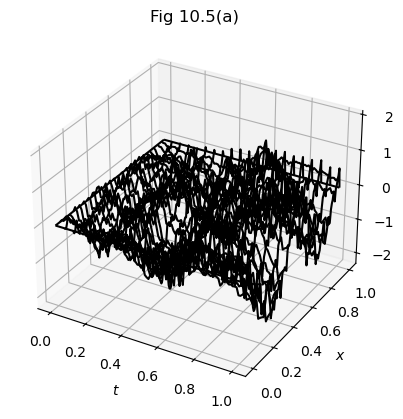

In [31]:
dtref=0.01; kappa=100; r=1/2; J=128; a=1
bj = get_onedD_bj(dtref, J, a, r)
dW = get_onedD_dW(bj, kappa, 0, 1)

WW=np.zeros((J+1,101)); t=np.linspace(0, 1, 101)
for k in range(100):
  dW = get_onedD_dW(bj, 1, 0, 1)
  WW[1:-1, k+1] = WW[1:-1, k] + dW
  # t[k+1] = (k+1) * dtref

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
[T,X]=np.meshgrid(t,np.linspace(0,a,J+1))
CS=ax.plot_wireframe(T,X,WW,rstride=5,cstride=5,colors='k')
s=ax.set_xlabel(r'$t$')
s=ax.set_ylabel(r'$x$')
s=ax.set_zlabel(r'$W$')
s=ax.set_title(r'Fig 10.5(a)') 
#
# fig, ax = plt.subplots(figsize=(8, 6))
# [T,X]=np.meshgrid(t,np.linspace(0,a,J+1))
# CS=ax.contourf(T,X,WW, levels=20, cmap='jet')
# plt.colorbar(CS, ax=ax)
# s=ax.set_xlabel(r'$t$')
# s=ax.set_ylabel(r'$x$')
# s=ax.set_title(r'Fig 10.5(a)') 
# plt.show()

In [33]:
def Get_oned_bj(dtref, J, a, r):
    j = np.hstack([np.arange(1, J//2 + 1), np.arange(-J//2+1, 0)])
    eps = 0.001
    qj = np.hstack([0], np.abs(j)**(-(2*r + 1 + eps)/2))
    bj = sqrt(qj * dtref / a) * J
    return bj

def Get_oned_dW(bj, kappa, iFspace, M):
    J = bj.size
    if kappa == 1:
        nn = np.random.randn(M, J)
    else:
        nn = np.sum(np.random.randn(kappa, M, J), 0)
    nn = np.vstack([nn[0:1,:],
                   (nn[1:J//2,:] + 1j * nn[J//2 + 1:J,:]) / sqrt(2),
                   nn[J//2:J//2+1,:],
                   (nn[J//2-1:0:-1,:] - 1j * nn[J-1:J // 2 :-1,:])/ sqrt(2)])
    X = bj * nn
    if iFspace == 1:
        dW = X
    else:
        dW = np.real(ifft(X))
    return dW

def Get_twod_bj(dtref, J, a, alpha):
    lambdax = 2 * pi * np.hstack([np.arange(0,J[0]//2 +1), np.arange(- J[0]//2 + 1,0)]) / a[0]
    lambday = 2 * pi * np.hstack([np.arange(0,J[1]//2 +1), np.arange(- J[1]//2 + 1,0)]) / a[1]
    lambdaxx, lambdayy = np.meshgrid(lambdax, lambday, indexing='ij')
    sqrt_qj = np.exp(- alpha * (lambdaxx ** 2 + lambdayy ** 2))
    bj = sqrt_qj * sqrt(dtref) * J[0] * J[1] / sqrt(a[0] * a[1])
    return bj

def Get_twod_dW(bj, kappa, M):
    J=bj.shape
    if (kappa == 1):
        nn=np.random.randn(M,J[0],J[1],2)
    else:
        nn=np.sum(np.random.randn(kappa,M,J[0],J[1],2),0)
    nn2=np.dot(nn,np.array([1,1j]))
    tmp=ifft2(bj*nn2)
    dW1=np.real(tmp)
    dW2=np.imag(tmp)
    return dW1, dW2

(1, 512, 512) (1, 512, 512)


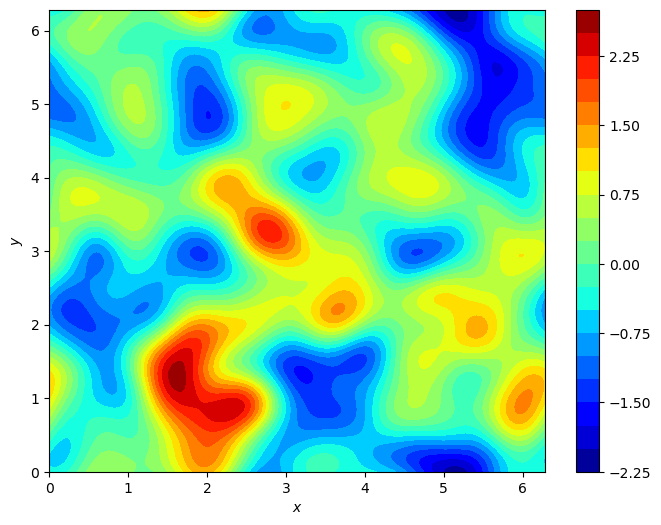

In [ ]:
J=[512, 512]; dtref=0.01; kappa=100; a=[2*pi, 2*pi]
alpha=0.05; bj = Get_twod_bj(dtref, J, a, alpha)
W1, W2 = Get_twod_dW(bj, kappa, 1)
print(W1.shape, W2.shape)

W = np.zeros((J[0], J[1], 101))
t = np.linspace(0, 1, 101)
for k in range(0, 99, 2):
    W1, W2 = Get_twod_dW(bj, 1, 1)
    W[:, :, k + 1] = W[:, :, k] + W1[0, :, :]
    W[:, :, k + 2] = W[:, :, k + 1] + W2[0, :, :]
#
gridx = np.linspace(0, a[0], J[0])
gridy = np.linspace(0, a[1], J[1])
fig, ax = plt.subplots(figsize=(8, 6))
CS=ax.contourf(gridy,gridx,W[:, :, -1], 20, cmap='jet')
s=ax.set_xlabel(r'$x$')
s=ax.set_ylabel(r'$y$')
s=plt.colorbar(CS)

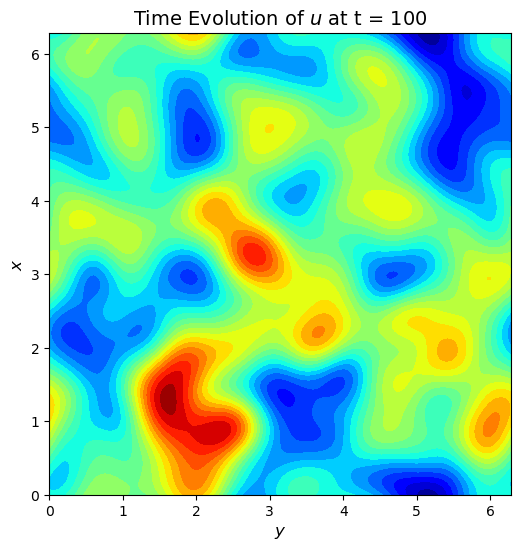

In [40]:
from matplotlib.animation import FuncAnimation, PillowWriter
gridx = np.linspace(0, a[0], J[0])
gridy = np.linspace(0, a[1], J[1])
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(gridy, gridx, W[:, :, 0], 20, cmap='jet')
ax.set_xlabel(r'$y$', fontsize=12)
ax.set_ylabel(r'$x$', fontsize=12)
ax.set_title('Time Evolution of $u$ at t = 0', fontsize=14)
ax.set_aspect('equal')

def update(frame):
    ax.clear() 
    contour = ax.contourf(gridy, gridx, W[:, :, frame], 20, cmap='jet')
    ax.set_xlabel(r'$y$', fontsize=12)
    ax.set_ylabel(r'$x$', fontsize=12)
    ax.set_title(f'Time Evolution of $u$ at t = {frame}', fontsize=14)
    ax.set_aspect('equal')
    return contour

ani = FuncAnimation(fig, update, frames= 101, interval=100*dtref, blit=False)
ani.save('evolution.gif', writer=PillowWriter(fps=10))
plt.show()